In [1]:
### imports
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
### constants
x = np.loadtxt("X.txt", dtype=float, delimiter=',', unpack=True)
y = np.loadtxt("Y.txt", dtype=int, delimiter=',')

RATE = 1
EPSILON = 0.001

COLORS = ['red', 'orange', 'green', 'blue']

In [3]:
### useful functions
def binary_classify(x, w):
    """classify a data point by the sign function"""
    return np.sign(np.dot(w.T, x))

def error_count(w, clas):
    """calculate error rate of logistic using binary classification"""
    errors = []
    for i in range(len(y)):
        fac = 1 if y[i] == clas else -1
        equal = (np.sign(sig(np.dot(w.T, x[i]))-0.5) == fac)
        if equal:
            errors.append(i)
    return errors

def sig(x):
    """define the sigmoid function"""
    return 1 / (1 + np.exp(-x))

def error_rate_logistic(w, clas):
    """count the number of points classified incorrectly by logistic regression"""
    sum = 0
    for i in range(len(y)):
        fac = 1 if y[i] == clas else -1
        sum += sig(fac * np.dot(w.T, x[i])) * (fac * x[i])
    return sum / len(y)

def logistic_regression(w, clas):
    """run logistic regression on the dataset"""
    fix = 0
    while 1:
        fix += 1
        w -= RATE * error_rate_logistic(w, clas)
        error = error_rate_logistic(w, clas)
        if np.linalg.norm(error) <= EPSILON:
            break
    return fix

def error_rate_logistic_ovo(w, pair:tuple):
    """error rate gradient for 2 classes only"""
    sum = 0
    for i in itertools.chain(range((pair[0]-1)*20, pair[0]*20), range((pair[1]-1)*20, pair[1]*20)):
        fac = 1 if y[i] == pair[0] else -1
        sum += sig(fac * np.dot(w.T, x[i])) * (fac * x[i])
    return sum / 40

def logistic_regression_ovo(w, pair):
    """logistic regression for 2 classes only"""
    fix = 0
    while 1:
        fix += 1
        w -= RATE * error_rate_logistic_ovo(w, pair)
        error = error_rate_logistic_ovo(w, pair)
        if np.linalg.norm(error) <= EPSILON:
            break
    return fix

def slope(v):
    return 0 - (v[1] / v[2]) if v[2] != 0 else float("-inf")

def intercept(v):
    return 0 - (v[0] / v[2]) if v[2] != 0 else float("-inf")

def printw(w):
    """print the w vector beautifully"""
    p = "["
    for f in w:
        space = '' if f < 0 else ' '
        p += "%s%f " %(space, f)
    return p[:-1] + ']'

w1: [ 3.205355  1.060028  1.155025]
w2: [ 3.938025 -1.199244 -2.139113]
w3: [ 10.085220  4.768700 -3.096587]
w4: [ 4.296037 -2.231531  1.591240]

Error rates:
w1: 07/80 = 0.0875
w2: 04/80 = 0.0500
w3: 00/80 = 0.0000
w4: 01/80 = 0.0125

Total error rate: 12/80 = 0.1500


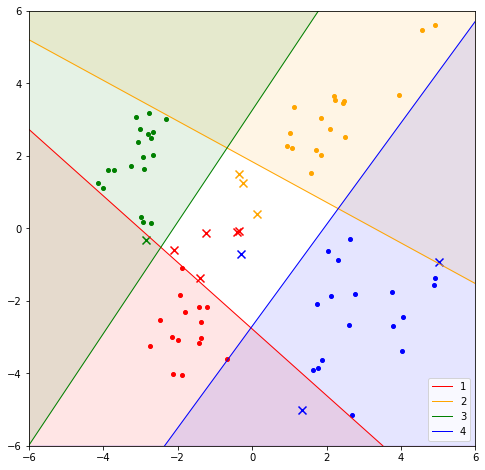

In [4]:
### one versus all

# w matrix for storing w of all 4 classes
w = np.zeros((4, 3))

# run logistic regression on all classes
for i in range(4):
    logistic_regression(w[i], i+1)
    print("w%d:" %(i+1), printw(w[i]))

# calculate error rates
errors = np.zeros(4)
error = 0
error_set = set()
print("\nError rates:")
for i in range(4):
    count = error_count(w[i], y[i*20])
    errors[i] = len(count)  # number of errors
    error += errors[i]      # add to total errors
    error_set.update(count) # update the set of error points
    print("w%d: %02d/80 = %.4f" %(i+1, errors[i], errors[i]/80))
print("\nTotal error rate: %d/80 = %.4f" %(len(error_set), len(error_set)/80))

# plot decision boundaries
fig, ax = plt.subplots(figsize=(8, 8))
ran = np.array([-6, 6])
for i in range(4):
    c = intercept(w[i])
    m = slope(w[i])
    ax.axline((0, c), slope=m, linewidth=1, color=COLORS[i], label=(i+1))
    plt.fill_between(ran, m*ran+c, -6*np.sign(int(w[i][1] < w[i][2])-0.5), color=COLORS[i], alpha=0.1)
ax.legend()

# plot points
for i in range(80):
    m = 'x' if i in error_set else '.'
    plt.scatter(x[i][1], x[i][2], color=COLORS[y[i]-1], s=64, marker=m)
plt.xlim(ran)
plt.ylim(ran)
plt.show()

1 vs 2: [-0.682615  5.840088  7.147900]
1 vs 3: [-8.247054 -4.670492  7.318378]
1 vs 4: [ 5.640537  20.493188 -1.475594]
2 vs 3: [-3.558887 -5.413367 -1.510769]
2 vs 4: [-0.773057  1.499088 -6.658255]
3 vs 4: [ 2.001376  2.788652 -2.967764]

Error rate: 0/80 = 0.0000


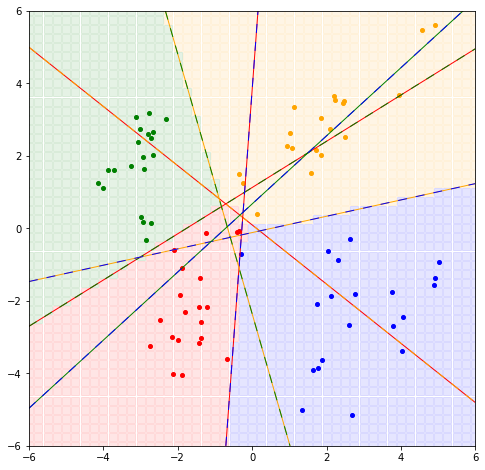

In [5]:
### one versus one

# w matrix for storing w for all 4c2 = 6 classifications
w = np.zeros((6, 3))

# [(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]
pairs = list(itertools.combinations((1, 2, 3, 4), 2))

# run logistic regression on all classes
for i in range(6):
    logistic_regression_ovo(w[i], pairs[i])
    print("%d vs %d:" %(pairs[i][0], pairs[i][1]), printw(w[i]))

# classify each point
error_set = set()
for i in range(80):
    fac = 1 if y[i] == (i//20) else -1
    pr = [0, 0, 0, 0] # probability of point belonging in each class
    for j in range(6):
        p = sig(fac * np.dot(w[j].T, x[i]))
        pr[pairs[j][0]-1] += p      # probability of point belonging in pairs[j][0]
        pr[pairs[j][1]-1] += (1-p)  # probability of point belonging in pairs[j][1]
    if np.argmax(pr)+1 != y[i]:     # error if highest probability != real class
        error_set.add(i)
print("\nError rate: %0d/80 = %.4f" %(len(error_set), len(error_set)/80))

# plot
fig, ax = plt.subplots(figsize=(8, 8))

# shade boundaries
for a in np.arange(-6, 6.1, step=0.25):
    for b in np.arange(-6, 6.1, step=0.25):
        pr = [0, 0, 0, 0]
        for j in range(6):
            p = sig(np.dot(w[j].T, [1, a, b]))
            pr[pairs[j][0]-1] += (1-p)
            pr[pairs[j][1]-1] += p
        plt.scatter(a, b, color=COLORS[np.argmax(pr)], s=80, marker="s", alpha=0.1)

# plot decision boundaries
for i in range(6):
    c = intercept(w[i])
    m = slope(w[i])
    ax.axline((0, c), slope=m, linewidth=1, color=COLORS[pairs[i][0]-1])
    ax.axline((0, c), slope=m, linewidth=1, color=COLORS[pairs[i][1]-1], dashes=(9, 9))

# plot points
for i in range(80):
    m = 'x' if i in error_set else '.'
    plt.scatter(x[i][1], x[i][2], color=COLORS[y[i]-1], s=64, marker=m)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.show()